In [113]:
import numpy as np
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.ops import unary_union
from rasterio.features import rasterize
from shapely.geometry import mapping

In [122]:
#Open image and display
raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path,"r", driver = 'JP2OpenJPEG') as src:
    raster_img = src.read()
    raster_meta = src.meta

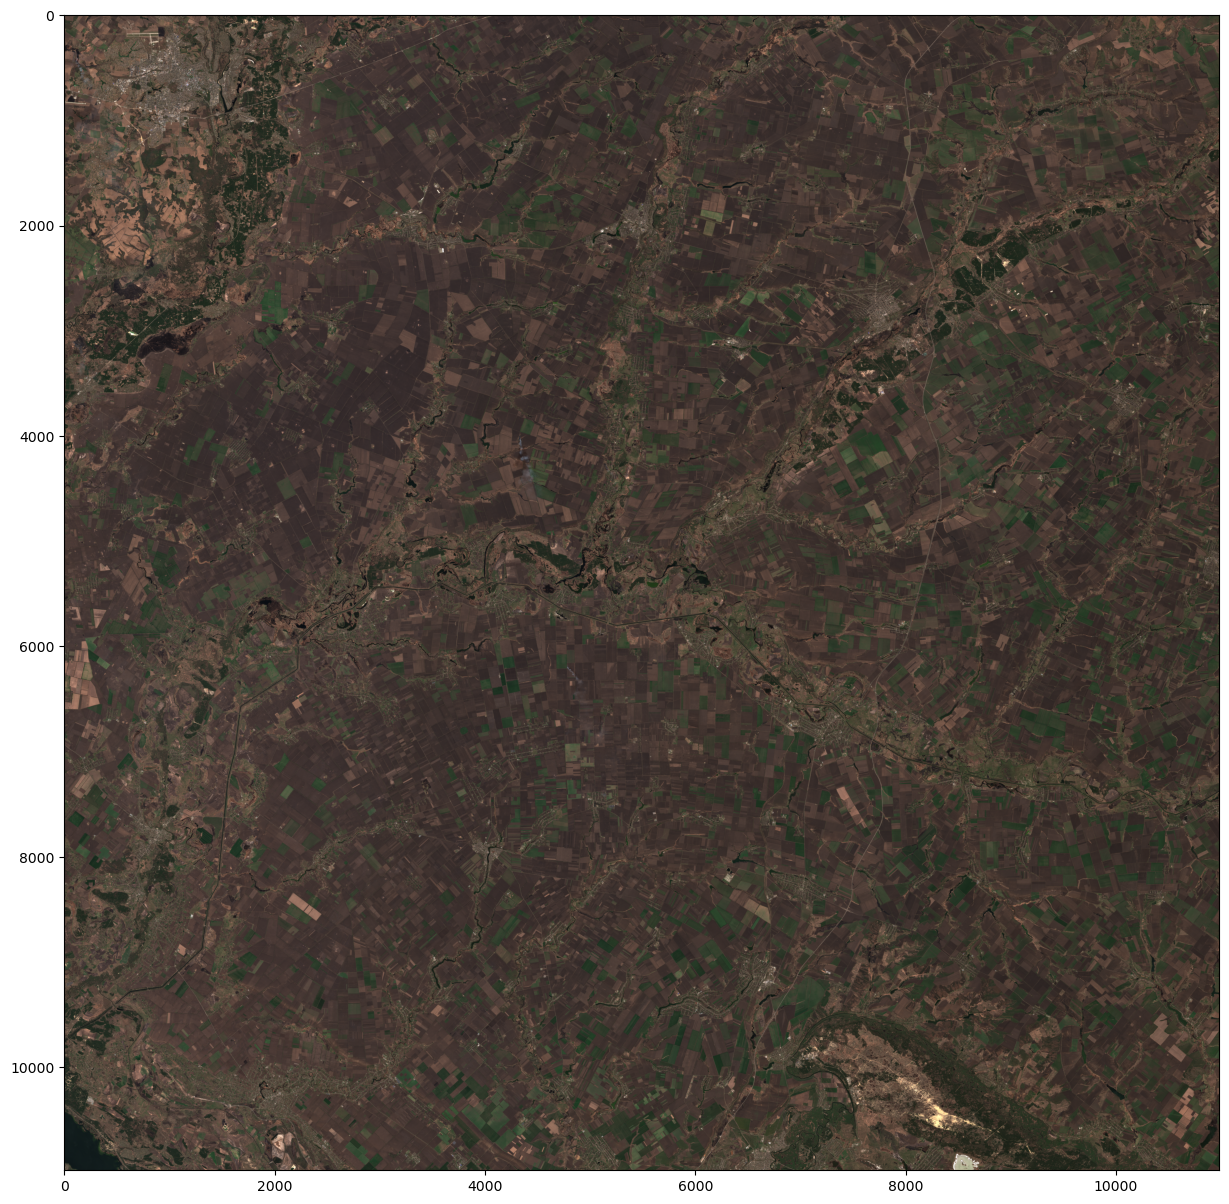

In [123]:
raster_img = reshape_as_image(raster_img)
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [116]:
#Read vector mask data
train_df = gpd.read_file('mask/Masks_T36UXV_20190427.shp')
train_df[train_df.geometry.notnull()]


,id,Data,Code,Descriptio,Comments,Image,geometry
0,NaN,NaN,2.0,branch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,NaN,NaN,2.0,brahch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."
...,...,...,...,...,...,...,...
931,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.60033 49.04547, 35.60011 49.04496..."
932,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.59042 49.04165, 35.59127 49.04155..."
933,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.60754 49.05593, 35.60796 49.05600..."
934,NaN,NaN,1.0,color+ structure,NaN,T36UXV_20190427T083601,"POLYGON ((35.52378 48.76951, 35.52332 48.76918..."


In [117]:
# Redesign vector data to match raster data
train_df = train_df.to_crs(raster_meta['crs'])

In [118]:
# Determine a function to convert polygon coordinates to raster coordinates
def poly_from_utm(polygon,transform):
    poly_pts = []
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        poly_pts.append(~transform * tuple(i))
    new_poly = Polygon(poly_pts)
    return new_poly

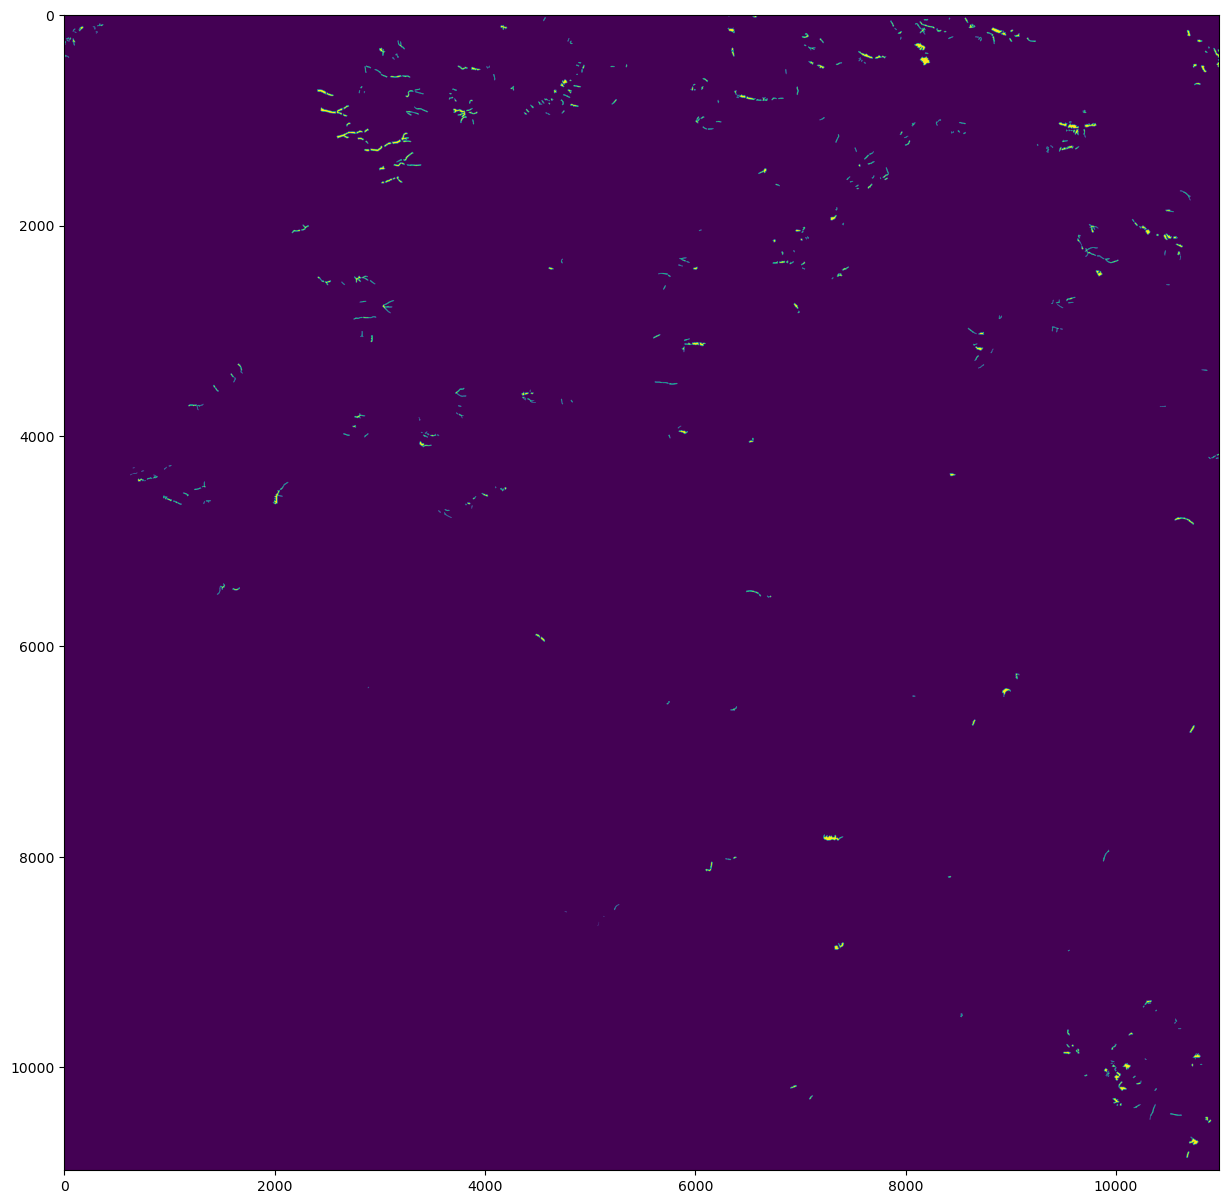

In [120]:
# Convert vector polygons to raster mask
poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'] is None:
        continue
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)
mask = rasterize(shapes=poly_shp, out_shape=im_size)
#plotting the mask
plt.figure(figsize=(15,15))
plt.imshow(mask)